In [3]:
from catalogue import *
import lime
import lime.lime_tabular
import lime as lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV

/opt/conda/lib/python2.7/site-packages/astropy/table/np_utils.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _np_utils
/opt/conda/lib/python2.7/site-packages/astropy/io/ascii/fastbasic.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cparser
Using TensorFlow backend.
/opt/conda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load training data, see catalogue.py for load data function.
----
### I apply one colour cut to remove the A type stars from our sample, and one $log{(g)}$ cut. 


In [65]:
inputs, outputs, error, df_original = load_data()
#seed = 7
#inputs, outputs, error, df_original = inputs.sample(frac=0.1, random_state=seed), outputs.sample(frac=0.1, random_state=seed), error.sample(frac=0.1, random_state=seed), df_original.sample(frac=0.1, random_state=seed)

print "Number of stars for training before any cuts:", inputs.shape[0]

inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])

# take out all cuts. 

m = 0.42 # u - g slope for A type star cut
b = 0.28 # g - r slope for A type star cut

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r']) #& (m*inputs['u-g'] + b > inputs['g-r'])

a_star=inputs[colour_cut_a] # Keep track of A type stars

# Apply same cuts to each of our dataframes.
outputs=outputs[colour_cut_b]
error=error[colour_cut_b]
inputs=inputs[colour_cut_b]

# Theoretical colour cuts to remove contaminents. Ideally, we want our model to recognize 
# contaminents. 
# ui_thres = 1.3
# gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

# Here I might apply a cut in quality of the data.
input_forML2 = inputs#[(inputs['dg'] < 0.008)]#[ml_cut]
output_forML2 = outputs#[(inputs['dg'] < 0.008)]#[ml_cut]
error_forML2 = error#[(inputs['dg'] < 0.008)]#[ml_cut]

# Apply above loegg error threshold. i.e. select only stars with good logg data
logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

# Randomize the index after cuts, and assign to new inputs for ML
input_ML2 = input_forML2[logg_cut].reset_index(drop=True)
output_ML2 = output_forML2[logg_cut].reset_index(drop=True)
error_ML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_ML2['logg_binary'] = np.where(output_ML2['logg'] > 3.5, 'dwarf', 'giant')

print "Number of stars after cuts:", input_ML2.shape[0]

Number of stars for training before any cuts: 142750
Number of stars after cuts: 124482


In [90]:
input_ML2.sample(frac=1) # randomly shuffle order of pandas dataframe

# Normalize the data using custom normalize function
# default is using mean and stdev. Errors use min_max method
inputf = normalize(input_ML2)
outputf = normalize(output_ML2)
errorf = normalize(error_ML2, 'min_max')

seed = 7 # Removes any predictablility in our k-fold splits. Completely random.

np.random.seed(seed)

inputs_col = pd.DataFrame()

inputs_col['u-g']=inputf['u']-inputf['g']
inputs_col['g-r']=inputf['g']-inputf['r']
inputs_col['r-i']=inputf['r']-inputf['i']
inputs_col['i-z']=inputf['i']-inputf['z']
inputs_col['z-y']=inputf['z']-inputf['y']
inputs_col['u-G']=inputf['u']-inputf['G']
inputs_col['u-RP']=inputf['u']-inputf['RP']
inputs_col['u-BP']=inputf['u']-inputf['BP']


# convert our inputs into a numpy array
X = inputs_col.values.astype(float)

In [91]:
from sklearn.model_selection import train_test_split

inputf_train, inputf_test, outputf_train, outputf_test = train_test_split(inputs_col, outputf, test_size=0.2, random_state=42)
input_full_train, input_full_test, output_full_train, output_full_test = train_test_split(inputf, outputf, test_size=0.2, random_state=42)

In [92]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

encoder_train = LabelEncoder()
encoder_train.fit(outputf_train['logg_binary'])
encoded_Y_train = encoder.transform(outputf_train['logg_binary'])

encoder_test = LabelEncoder()
encoder_test.fit(outputf_test['logg_binary'])
encoded_Y_test = encoder.transform(outputf_test['logg_binary'])

# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(593, 594, 1),
              "max_depth": np.arange(15, 16, 1),
              "min_samples_split": np.arange(2,3,1),
              "min_samples_leaf": np.arange(1,2,1),
              "max_leaf_nodes": np.arange(1850,2000,10),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

In [93]:
new_model = False # True only if you want to cross-validate a model with new parameters.

#kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
#rf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, verbose=1, n_jobs=-1)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': np.arange(13, 18, 1),
    'max_features': [2, 3],
    'min_samples_leaf': np.arange(1,4,1),
    'min_samples_split': np.arange(2,5,1),
    'n_estimators': np.arange(1800, 1900, 1)
}


In [94]:
param_grid = {"n_estimators": np.arange(593, 594, 1),
              "max_depth": np.arange(15, 16, 1),
              "min_samples_split": np.arange(2,3,1),
              "min_samples_leaf": np.arange(1,2,1),
              "max_leaf_nodes": np.arange(1850,2000,10),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

crf = sklearn.ensemble.RandomForestClassifier(n_estimators=593, max_depth=15, min_samples_leaf=2, max_leaf_nodes=1850, verbose=1, n_jobs=-1)
crf.fit(inputf_train, encoded_Y_train)
rf = CalibratedClassifierCV(base_estimator=crf, method='sigmoid', cv='prefit')
rf.fit(inputf_train, encoded_Y_train)

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 593 out of 593 | elapsed:    5.6s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.8s finished


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=1850,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=593, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
            cv='prefit', method='sigmoid')

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


0.972068664533023


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


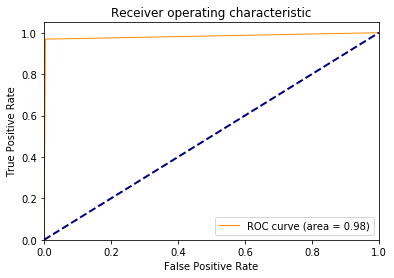

In [95]:
pred = rf.predict(inputf_test)
inputf_test['class_pred'] = pred
print(sklearn.metrics.f1_score(encoded_Y_test, pred, average='binary'))

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(encoded_Y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [96]:
def change_to_colour(input_test, input_train_col):
    # Make data to train on colours
    inputs_col = pd.DataFrame()

    inputs_col['u-g']=input_test['u']-input_test['g']
    inputs_col['g-r']=input_test['g']-input_test['r']
    inputs_col['r-i']=input_test['r']-input_test['i']
    inputs_col['i-z']=input_test['i']-input_test['z']
    inputs_col['z-y']=input_test['z']-input_test['y']
    inputs_col['u-G']=input_test['u']-input_test['G']
    inputs_col['u-RP']=input_test['u']-input_test['RP']
    inputs_col['u-BP']=input_test['u']-input_test['BP']
    
    inputs_col = normalize(inputs_col, df_1 = input_train_col, kind='custom')

    return inputs_col
 
def criteria_function(inputs_NGC, std_x, col_1, col_2):
    ra_cut = (inputs_NGC['pmra']>(inputs_NGC['pmra'].mean()-std_x*(inputs_NGC['pmra'].std()))) & (inputs_NGC['pmra']<(inputs_NGC['pmra'].mean()+std_x*(inputs_NGC['pmra'].std())))
    dec_cut = (inputs_NGC['pmdec']>(inputs_NGC['pmdec'].mean()-std_x*(inputs_NGC['pmdec'].std()))) & (inputs_NGC['pmdec']<(inputs_NGC['pmdec'].mean()+std_x*(inputs_NGC['pmdec'].std()))) 
    # Apply the color cuts for machine learning 
    ui_thres = 1.3
    gz_thres = 0.05
    #ml_cut =  (inputs_NGC['u']-inputs_NGC['i'] >= ui_thres) & (inputs_NGC['u']-inputs_NGC['i'] <= 2.6) & (inputs_NGC['g']-inputs_NGC['z'] >= gz_thres)
    criteria = ra_cut & dec_cut & (inputs_NGC['u']-inputs_NGC['G'] < col_1) & (inputs_NGC['u']-inputs_NGC['G'] > col_2)
    
    return criteria

def prob_frac(bin_width, inputs_NGC):
    bin_loc = []
    avg_prob_dwarf = []
    avg_prob_giant = []
    for data in inputs_NGC['G'].values:
        temp_df = inputs_NGC[(inputs_NGC['G'] < data+bin_width)&(inputs_NGC['G'] > data-bin_width)]
        avg_prob_dwarf.append(temp_df['dwarf'].mean())
        avg_prob_giant.append(temp_df['giant'].mean())
        bin_loc.append(data)
    return avg_prob_dwarf, avg_prob_giant, bin_loc

In [97]:
inputs_NGC6341 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6341.fits')
inputs_NGC6205 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6205.fits')
inputs_NGC5466 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5466.fits')
inputs_NGC5272 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5272.fits')

##############################
## NGC 6341 ##
##############################
criteria = criteria_function(inputs_NGC6341, 0.2, 2.5, 0)
inputs_NGC6341 = inputs_NGC6341[criteria]
inputs_NGC6341 = (inputs_NGC6341.dropna())
inputs_NGC6341_b = change_to_colour(inputs_NGC6341, inputs_col)
inputs_NGC6341['dwarf'] =  rf.predict_proba(inputs_NGC6341_b.values)[:,0]
inputs_NGC6341['giant'] =  rf.predict_proba(inputs_NGC6341_b.values)[:,1]
inputs_NGC6341['class_binary'] =  rf.predict(inputs_NGC6341_b.values)


##############################
## NGC 6205 ##
##############################
criteria = criteria_function(inputs_NGC6205, 0.13, 2.5, 0)
inputs_NGC6205 = inputs_NGC6205[criteria]
inputs_NGC6205 = (inputs_NGC6205.dropna())
inputs_NGC6205_b = change_to_colour(inputs_NGC6205, inputs_col)
inputs_NGC6205['dwarf'] =  rf.predict_proba(inputs_NGC6205_b.values)[:,0]
inputs_NGC6205['giant'] =  rf.predict_proba(inputs_NGC6205_b.values)[:,1]
inputs_NGC6205['class_binary'] =  rf.predict(inputs_NGC6205_b.values)

##############################
## NGC 5466 ##
##############################
criteria = criteria_function(inputs_NGC5466, 0.26, 2.5, 0)
inputs_NGC5466 = inputs_NGC5466[criteria]
inputs_NGC5466 = (inputs_NGC5466.dropna())
inputs_NGC5466_b = change_to_colour(inputs_NGC5466, inputs_col)
inputs_NGC5466['dwarf'] =  rf.predict_proba(inputs_NGC5466_b.values)[:,0]
inputs_NGC5466['giant'] =  rf.predict_proba(inputs_NGC5466_b.values)[:,1]
inputs_NGC5466['class_binary'] =  rf.predict(inputs_NGC5466_b.values)

##############################
## NGC 5272 ##
##############################
criteria = criteria_function(inputs_NGC5272, 0.14, 2.5, 0)
inputs_NGC5272 = inputs_NGC5272[criteria]
inputs_NGC5272 = (inputs_NGC5272.dropna())
inputs_NGC5272_b = change_to_colour(inputs_NGC5272, inputs_col)
inputs_NGC5272['dwarf'] =  rf.predict_proba(inputs_NGC5272_b.values)[:,0]
inputs_NGC5272['giant'] =  rf.predict_proba(inputs_NGC5272_b.values)[:,1]
inputs_NGC5272['class_binary'] =  rf.predict(inputs_NGC5272_b.values)

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 

In [98]:
def lum_frac(bin_width, inputs_NGC):
    fraction_giant = []
    fraction_dwarf = []
    bin_loc = []
    for data in inputs_NGC['G'].values:
        temp_df = inputs_NGC
        temp_df_giant = inputs_NGC[(inputs_NGC['G'] < data+bin_width)&(temp_df['G'] > data-bin_width) & (inputs_NGC['class_binary']==1)]
        temp_df_dwarf = inputs_NGC[(inputs_NGC['G'] < data+bin_width)&(temp_df['G'] > data-bin_width) & (inputs_NGC['class_binary']==0)]
        temp_df_all = inputs_NGC[(inputs_NGC['G'] < data+bin_width)&(temp_df['G'] > data-bin_width)]
        fraction_giant.append(float(temp_df_giant.shape[0])/temp_df_all.shape[0])
        fraction_dwarf.append(float(temp_df_dwarf.shape[0])/temp_df_all.shape[0])
        bin_loc.append(data)
    return bin_loc, fraction_giant, fraction_dwarf


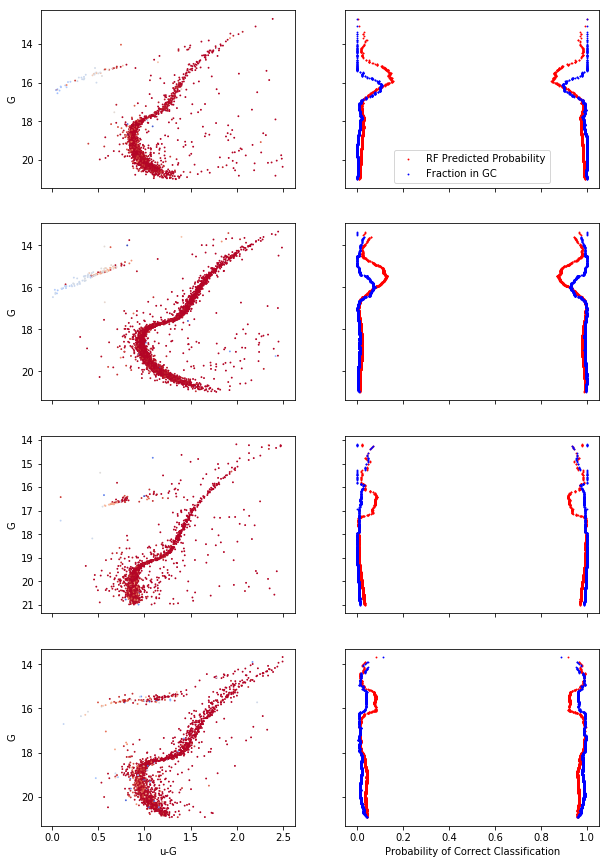

In [231]:
# Warning, takes a while to run..........

fig, ax = plt.subplots(4, 2, figsize=(10, 15),  sharex='col', sharey='row')

NGC6341_probs = prob_frac(0.5, inputs_NGC6341)
ax[0, 0].scatter((inputs_NGC6341['u']-inputs_NGC6341['G']).values, inputs_NGC6341['G'].values, s=0.75, c=inputs_NGC6341['dwarf'], cmap=plt.cm.coolwarm)
ax[0, 1].scatter(NGC6341_probs[0], NGC6341_probs[2], s=0.75, color='red', label='RF Predicted Probability')
ax[0, 1].scatter(NGC6341_probs[1], NGC6341_probs[2], s=0.75, color='red')
ax[0, 1].scatter(lum_frac(.5, inputs_NGC6341)[2], lum_frac(.5, inputs_NGC6341)[0], s=0.75, color='blue')
ax[0, 1].scatter(lum_frac(.5, inputs_NGC6341)[1], lum_frac(.5, inputs_NGC6341)[0], s=0.75, color='blue', label='Fraction in GC')
ax[0, 1].legend()
ax[0, 0].set_ylabel('G')
ax[0, 0].invert_yaxis()

NGC6205_probs = prob_frac(0.5, inputs_NGC6205)
ax[1, 0].scatter((inputs_NGC6205['u']-inputs_NGC6205['G']).values, inputs_NGC6205['G'].values, s=0.75, c=inputs_NGC6205['dwarf'], cmap=plt.cm.coolwarm)
ax[1, 1].scatter(NGC6205_probs[0], NGC6205_probs[2], s=0.75, color='red')
ax[1, 1].scatter(NGC6205_probs[1], NGC6205_probs[2], s=0.75, color='red')
ax[1, 1].scatter(lum_frac(.5, inputs_NGC6205)[2], lum_frac(.5, inputs_NGC6205)[0], s=0.75, color='blue')
ax[1, 1].scatter(lum_frac(.5, inputs_NGC6205)[1], lum_frac(.5, inputs_NGC6205)[0], s=0.75, color='blue')
ax[1, 0].set_ylabel('G')
ax[1, 0].invert_yaxis()

NGC5466_probs = prob_frac(0.5, inputs_NGC5466)
ax[2, 0].scatter((inputs_NGC5466['u']-inputs_NGC5466['G']).values, inputs_NGC5466['G'].values, s=0.75, c=inputs_NGC5466['dwarf'], cmap=plt.cm.coolwarm)
ax[2, 1].scatter(NGC5466_probs[0], NGC5466_probs[2], s=0.75, color='red')
ax[2, 1].scatter(NGC5466_probs[1], NGC5466_probs[2], s=0.75, color='red')
ax[2, 1].scatter(lum_frac(.5, inputs_NGC5466)[2], lum_frac(.5, inputs_NGC5466)[0], s=0.75, color='blue')
ax[2, 1].scatter(lum_frac(.5, inputs_NGC5466)[1], lum_frac(.5, inputs_NGC5466)[0], s=0.75, color='blue')
ax[2, 0].set_ylabel('G')
ax[2, 0].invert_yaxis()

NGC5272_probs = prob_frac(0.5, inputs_NGC5272)
ax[3, 0].scatter((inputs_NGC5272['u']-inputs_NGC5272['G']).values, inputs_NGC5272['G'].values, s=0.75, c=inputs_NGC5272['dwarf'], cmap=plt.cm.coolwarm)
ax[3, 1].scatter(NGC5272_probs[0], NGC5272_probs[2], s=0.75, color='red')
ax[3, 1].scatter(NGC5272_probs[1], NGC5272_probs[2], s=0.75, color='red')
ax[3, 1].scatter(lum_frac(.5, inputs_NGC5272)[2], lum_frac(.5, inputs_NGC5272)[0], s=0.75, color='blue')
ax[3, 1].scatter(lum_frac(.5, inputs_NGC5272)[1], lum_frac(.5, inputs_NGC5272)[0], s=0.75, color='blue')
ax[3, 0].invert_yaxis()
ax[3, 0].set_ylabel('G')
ax[3, 0].set_xlabel('u-G')
ax[3, 1].set_xlabel('Probability of Correct Classification')
plt.savefig('./plots/rf_col/random_forrest')

In [75]:
print(inputf_train.dtypes.index)
explainer = lime.lime_tabular.LimeTabularExplainer(inputf_train.values, feature_names = inputf_train.columns, discretize_continuous=True)

Index([u'u-g', u'g-r', u'r-i', u'i-z', u'z-y', u'u-G', u'u-RP', u'u-BP'], dtype='object')


In [87]:
# Take every giant/dwarf and get the mean feature separately to determine the median value of the feature. Do this for dwarfs/giants respectively
predict_fn = lambda x: rf.predict_proba(encoder.transform(x))


for i in range(0, 3):
    df_dwarf = inputf_test[inputf_test['class_pred']==1]
    df_dwarf = df_dwarf.drop(columns=['class_pred'])
    df_dwarf = df_dwarf.sample(frac=0.5)
    ints = range(0, df_dwarf.shape[0])
    print i

    lime_vals = []
    for index in ints:
        print index, 'of', len(ints)
        exp = explainer.explain_instance(df_dwarf.values[index], rf.predict_proba, num_features=inputf_train.columns.shape[0])
        lime_vals.append(exp.as_list())

    array = np.asarray(lime_vals)

    # This is only for dwarfs keep in mind
    low_a=[]
    high_a=[]
    feature_a=[]
    val_a = []
    for i in range(0, array.shape[0]):
        for j in range(0, array.shape[1]):
            instance = re.split("< | <= | >", array[i, j][0])
            if len(re.split("< | <= | >", array[i, j][0]))==2:
                feature = instance[0]
                low = instance[1]
                val = array[i,j,1]

                val_a.append(val)
                feature_a.append(feature)
                low_a.append(low)
                high_a.append('NaN')
            if len(re.split("< | <= | >", array[i, j][0]))==3:
                low = instance[0]
                feature = instance[1]
                high = instance[2]
                val = array[i,j,1]

                val_a.append(val)
                feature_a.append(feature)
                low_a.append(low)  
                high_a.append(high)

    df_lime_trans = pd.DataFrame()
    df_lime_trans['low'] = low_a
    df_lime_trans['high'] = high_a
    df_lime_trans['feature'] = feature_a
    df_lime_trans['val'] = val_a

    grouped = df_lime_trans.groupby('feature')

    df_lime = pd.DataFrame()

    p={}
    panel= pd.Panel(p)
    for name,group in grouped:
        p[name] = group
    panel = pd.Panel(p)

    low_median = [panel[name]['low'].dropna().astype(float).median() for name, group in grouped]
    high_median = [panel[name]['high'].dropna().astype(float).median() for name, group in grouped]
    val_median = [panel[name]['val'].dropna().astype(float).median() for name, group in grouped]
    name = [name for name,group in grouped ]

    df_lime['low'] = low_median
    df_lime['feature'] = name
    df_lime['high'] = high_median
    df_lime['val'] = val_median

    print df_lime.sort_values(by=['val'])


0
0 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


2 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


3 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


4 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


5 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


6 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


7 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


8 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


9 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


10 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


11 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


12 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


13 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


14 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


15 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


16 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


17 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


18 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


19 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


20 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


21 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


22 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


23 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


24 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


25 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


26 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


27 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


28 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


29 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


30 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


31 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


32 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


33 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


34 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


35 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


36 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


37 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


38 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


39 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


40 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


41 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


42 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


43 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


44 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


45 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


46 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


47 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


48 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


49 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


50 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


51 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


52 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


53 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


54 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


55 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


56 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


57 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


58 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


59 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


60 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


61 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


62 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


63 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


64 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


65 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


66 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


67 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


68 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


69 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


70 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


71 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


72 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


73 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


74 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


75 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


76 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


77 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


78 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


79 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


80 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


81 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


82 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


83 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


84 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


85 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


86 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


87 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


88 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


89 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


90 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


91 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


92 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


93 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


94 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


95 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


96 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


97 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


98 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


99 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


100 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


101 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


102 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


103 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


104 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


105 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


106 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


107 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


108 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


109 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


110 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


111 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


112 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


113 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


114 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


115 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


116 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


117 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


118 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


119 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


120 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


121 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


122 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


123 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


124 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


125 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


126 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


127 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


128 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


129 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


130 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


131 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


132 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


133 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


134 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


135 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


136 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


137 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


138 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


139 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


140 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


141 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


142 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


143 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


144 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


145 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


146 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


147 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


148 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


149 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


150 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


151 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


152 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


153 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


154 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


155 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


156 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


157 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


158 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


159 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


160 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


161 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


162 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


163 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


164 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


165 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


166 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


167 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


168 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


169 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


170 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


171 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


172 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


173 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    1.1s finished


174 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


175 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


176 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


177 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


178 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


179 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


180 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


181 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


182 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


183 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


184 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


185 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


186 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


187 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


188 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


189 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


190 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


191 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


192 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


193 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


194 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


195 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


196 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


197 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


198 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


199 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


200 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


201 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


202 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


203 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


204 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


205 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


206 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


207 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


208 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


209 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


210 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


211 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


212 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


213 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


214 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


215 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


216 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


217 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


218 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


219 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


220 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


221 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


222 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


223 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


224 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


225 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


226 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


227 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


228 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


229 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


230 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


231 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


232 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


233 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


234 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


235 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


236 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


237 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


238 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


239 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


240 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


241 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


242 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


243 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


244 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


245 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


246 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


247 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


248 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


249 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


250 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


251 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


252 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


253 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


254 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


255 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


256 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


257 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


258 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


259 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


260 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


261 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


262 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


263 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


264 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


265 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


266 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


267 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


268 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


269 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


270 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


271 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


272 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


273 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


274 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


275 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


276 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


277 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


278 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


279 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


280 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


281 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


282 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


283 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


284 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


285 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


286 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


287 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


288 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


289 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


290 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


291 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


292 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


293 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


294 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


295 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


296 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


297 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


298 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


299 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


300 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


301 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


302 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


303 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


304 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


305 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


306 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


307 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


308 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


309 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


310 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


311 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


312 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


313 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


314 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


315 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


316 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


317 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


318 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


319 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


320 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


321 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


322 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


323 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


324 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


325 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


326 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


327 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


328 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


329 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


330 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


331 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


332 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


333 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


334 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


335 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


336 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


337 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


338 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


339 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


340 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


341 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


342 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


343 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


344 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


345 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


346 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


347 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


348 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


349 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


350 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


351 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


352 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


353 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


354 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


355 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


356 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


357 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


358 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


359 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


360 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


361 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


362 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


363 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


364 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


365 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


366 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


367 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


368 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


369 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


370 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


371 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


372 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


373 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


374 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


375 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


376 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


377 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


378 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


379 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


380 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


381 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


382 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


383 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


384 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


385 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


386 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


387 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


388 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


389 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


390 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


391 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


392 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


393 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


394 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


395 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


396 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


397 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


398 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


399 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


400 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


401 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


402 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


403 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


404 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


405 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


406 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


407 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


408 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


409 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


410 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


411 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


412 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


413 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


414 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


415 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


416 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


417 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


418 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


419 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


420 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


421 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


422 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


423 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


424 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


425 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


426 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


427 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


428 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


429 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


430 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


431 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


432 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


433 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


434 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


435 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


436 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


437 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


438 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


439 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


440 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


441 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


442 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


443 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


444 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


445 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


446 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


447 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


448 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


449 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


450 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


451 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


452 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


453 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


454 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


455 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


456 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


457 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


458 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


459 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


460 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


461 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


462 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


463 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


464 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


465 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


466 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


467 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


468 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


469 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


470 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


471 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


472 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


473 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


474 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


475 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


476 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


477 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


478 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


479 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


480 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


481 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


482 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


483 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


484 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


485 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


486 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


487 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


488 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


489 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


490 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


491 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


492 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


493 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


494 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


495 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


496 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


497 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


498 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


499 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


500 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


501 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


502 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


503 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


504 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


505 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


506 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


507 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


508 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


509 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


510 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


511 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


512 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


513 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


514 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


515 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


516 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


517 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


518 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


519 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


520 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


521 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


522 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


523 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


524 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


525 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


526 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


527 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


528 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


529 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


530 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


531 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


532 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


533 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


534 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


535 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


536 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


537 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


538 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


539 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


540 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


541 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


542 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


543 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


544 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


545 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


546 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


547 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


548 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


549 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


550 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


551 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


552 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


553 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


554 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


555 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


556 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


557 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


558 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


559 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


560 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


561 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


562 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


563 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


564 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


565 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


566 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


567 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


568 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


569 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


570 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


571 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


572 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


573 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


574 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


575 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


576 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


577 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


578 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


579 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


580 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


581 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


582 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


583 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


584 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


585 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


586 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


587 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


588 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


589 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


590 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


591 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


592 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


593 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


594 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


595 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


596 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


597 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


598 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


599 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


600 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


601 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


602 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


603 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


604 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


605 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


606 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


607 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


608 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


609 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


610 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


611 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


612 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


613 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


614 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


615 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


616 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


617 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


618 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


619 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


620 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


621 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


622 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


623 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


624 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


625 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


626 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


627 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


628 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


629 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


630 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


631 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


632 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


633 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


634 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


635 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


636 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


637 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


638 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


639 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


640 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


641 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


642 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


643 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


644 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


645 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


646 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


647 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


648 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


649 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


650 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


651 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


652 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


653 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


654 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


655 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


656 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


657 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


658 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


659 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


660 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


661 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


662 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


663 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


664 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


665 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


666 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


667 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


668 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


669 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


670 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


671 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


672 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


673 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


674 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


675 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


676 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


677 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


678 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


679 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


680 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


681 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


682 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


683 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


684 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


685 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


686 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


687 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


688 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


689 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


690 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


691 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


692 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


693 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


694 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


695 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


696 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


697 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


698 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


699 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


700 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


701 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


702 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


703 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


704 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


705 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


706 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


707 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


708 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


709 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


710 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


711 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


712 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


713 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


714 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


715 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


716 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


717 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


718 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


719 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


720 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


721 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


722 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


723 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


724 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


725 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


726 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


727 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


728 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


729 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


730 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


731 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


732 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


733 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


734 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


735 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


736 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


737 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


738 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


739 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


740 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


741 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


742 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


743 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


744 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


745 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


746 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


747 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


748 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


749 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


750 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


751 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


752 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


753 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


754 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


755 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


756 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


757 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


758 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


759 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


760 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


761 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


762 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


763 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


764 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


765 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


766 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


767 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


768 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


769 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


770 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


771 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


772 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


773 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


774 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


775 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


776 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


777 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


778 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


779 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


780 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


781 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


782 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


783 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


784 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


785 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


786 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


787 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


788 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


789 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


790 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


791 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


792 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


793 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


794 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


795 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


796 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


797 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


798 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


799 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


800 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


801 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


802 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


803 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


804 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


805 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


806 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


807 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


808 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


809 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


810 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


811 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


812 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


813 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


814 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


815 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


816 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


817 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


818 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


819 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


820 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


821 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


822 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


823 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


824 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


825 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


826 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


827 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


828 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


829 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


830 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


831 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


832 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


833 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


834 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


835 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


836 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


837 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


838 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


839 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


840 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


841 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


842 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


843 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


844 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


845 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


846 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


847 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


848 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


849 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


850 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


851 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


852 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


853 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


854 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


855 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


856 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


857 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


858 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


859 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


860 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


861 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


862 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


863 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


864 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


865 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


866 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


867 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


868 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


869 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


870 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


871 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


872 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


873 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


874 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


875 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


876 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


877 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


878 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


879 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


880 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


881 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


882 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


883 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


884 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


885 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


886 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


887 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


888 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


889 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


890 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


891 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


892 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


893 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


894 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


895 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


896 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


897 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


898 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


899 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


900 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


901 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


902 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


903 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


904 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


905 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


906 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


907 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


908 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


909 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


910 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


911 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


912 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


913 of 1730


[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


914 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


915 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


916 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


917 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


918 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


919 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


920 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


921 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


922 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


923 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


924 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


925 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


926 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


927 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


928 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


929 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


930 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


931 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


932 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


933 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


934 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


935 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


936 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


937 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


938 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


939 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


940 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


941 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


942 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


943 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


944 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


945 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


946 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


947 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


948 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


949 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


950 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


951 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


952 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


953 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


954 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


955 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


956 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


957 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


958 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


959 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


960 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


961 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


962 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


963 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


964 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


965 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


966 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


967 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


968 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


969 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


970 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


971 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


972 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


973 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


974 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


975 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


976 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


977 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


978 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


979 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


980 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


981 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


982 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


983 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


984 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


985 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


986 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


987 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


988 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


989 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


990 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


991 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


992 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


993 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


994 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


995 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


996 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


997 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


998 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


999 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1000 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1001 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1002 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1003 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1004 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1005 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1006 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1007 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1008 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1009 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1010 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1011 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1012 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1013 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1014 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1015 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1016 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1017 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1018 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1019 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1020 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1021 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1022 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1023 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1024 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1025 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1026 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1027 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1028 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1029 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1030 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1031 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1032 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1033 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1034 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1035 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1036 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1037 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1038 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1039 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1040 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1041 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1042 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1043 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1044 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1045 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1046 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1047 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1048 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1049 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1050 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1051 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1052 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1053 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1054 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1055 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1056 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1057 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1058 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1059 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1060 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1061 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1062 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1063 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1064 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1065 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1066 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1067 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1068 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1069 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1070 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1071 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1072 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1073 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1074 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1075 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1076 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1077 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1078 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1079 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1080 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1081 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1082 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1083 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1084 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1085 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1086 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1087 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1088 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished


1089 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1090 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1091 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1092 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1093 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1094 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1095 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1096 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1097 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1098 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1099 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1100 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1101 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1102 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1103 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1104 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1105 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1106 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1107 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1108 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1109 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1110 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1111 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1112 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1113 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1114 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1115 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1116 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1117 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1118 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1119 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1120 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1121 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1122 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1123 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1124 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1125 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1126 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1127 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1128 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1129 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1130 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1131 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1132 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1133 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1134 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1135 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1136 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1137 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1138 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1139 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1140 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1141 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1142 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1143 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1144 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1145 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1146 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1147 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1148 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1149 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1150 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1151 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1152 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1153 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1154 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1155 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1156 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1157 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1158 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1159 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1160 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1161 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1162 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1163 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1164 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1165 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1166 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1167 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1168 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1169 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1170 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1171 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1172 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1173 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1174 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1175 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1176 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1177 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1178 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1179 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1180 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1181 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1182 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1183 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1184 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1185 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1186 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1187 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1188 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1189 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1190 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1191 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1192 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1193 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1194 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1195 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1196 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1197 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1198 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1199 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1200 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1201 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1202 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1203 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1204 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1205 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1206 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1207 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1208 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1209 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1210 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1211 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1212 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1213 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1214 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1215 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1216 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1217 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1218 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1219 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1220 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1221 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1222 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1223 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1224 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1225 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1226 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1227 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1228 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1229 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1230 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1231 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1232 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1233 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1234 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1235 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1236 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1237 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1238 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1239 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1240 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1241 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1242 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1243 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1244 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1245 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1246 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1247 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1248 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1249 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1250 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1251 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1252 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1253 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1254 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1255 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1256 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1257 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1258 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1259 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1260 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1261 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1262 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1263 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1264 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1265 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1266 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1267 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1268 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1269 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1270 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1271 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1272 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1273 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1274 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1275 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1276 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1277 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1278 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1279 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1280 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1281 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1282 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1283 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1284 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1285 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1286 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1287 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1288 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1289 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1290 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1291 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1292 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1293 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1294 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1295 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1296 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1297 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1298 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1299 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1300 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1301 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1302 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1303 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1304 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1305 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1306 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1307 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1308 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1309 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1310 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1311 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1312 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1313 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1314 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1315 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1316 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1317 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1318 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1319 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1320 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1321 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1322 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1323 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1324 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1325 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1326 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1327 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1328 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1329 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1330 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1331 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1332 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1333 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1334 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1335 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1336 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1337 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1338 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1339 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1340 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1341 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1342 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1343 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1344 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1345 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1346 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1347 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1348 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1349 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1350 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1351 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1352 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1353 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1354 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1355 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1356 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1357 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1358 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1359 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1360 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1361 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1362 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1363 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1364 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1365 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1366 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1367 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1368 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1369 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1370 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1371 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1372 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1373 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1374 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1375 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1376 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1377 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1378 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1379 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1380 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1381 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1382 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1383 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1384 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1385 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1386 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1387 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1388 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1389 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1390 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1391 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1392 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1393 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1394 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1395 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1396 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1397 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1398 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1399 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1400 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1401 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1402 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1403 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1404 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1405 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1406 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1407 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1408 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1409 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1410 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1411 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1412 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1413 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1414 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1415 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1416 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1417 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1418 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1419 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1420 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1421 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1422 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1423 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1424 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1425 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1426 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1427 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1428 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1429 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1430 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1431 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1432 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1433 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1434 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1435 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1436 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1437 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1438 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1439 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1440 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1441 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1442 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1443 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1444 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1445 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1446 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1447 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1448 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1449 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1450 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1451 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1452 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1453 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1454 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1455 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1456 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1457 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1458 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1459 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1460 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1461 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1462 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1463 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1464 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1465 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1466 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1467 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1468 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1469 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1470 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1471 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1472 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1473 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1474 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1475 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1476 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1477 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1478 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1479 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1480 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1481 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1482 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1483 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1484 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1485 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1486 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1487 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1488 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1489 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1490 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1491 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1492 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1493 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1494 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1495 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1496 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1497 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1498 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1499 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1500 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1501 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1502 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1503 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1504 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1505 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1506 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1507 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1508 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1509 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1510 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1511 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1512 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1513 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1514 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1515 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1516 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1517 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1518 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1519 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1520 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1521 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1522 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1523 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1524 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1525 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1526 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1527 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1528 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1529 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1530 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1531 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1532 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1533 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1534 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1535 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1536 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1537 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1538 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1539 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1540 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1541 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1542 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1543 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1544 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1545 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1546 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1547 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1548 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1549 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1550 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1551 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1552 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1553 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1554 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1555 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1556 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1557 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1558 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1559 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1560 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1561 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1562 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1563 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1564 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1565 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1566 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1567 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1568 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1569 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1570 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1571 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1572 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1573 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1574 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1575 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1576 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1577 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1578 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1579 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1580 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1581 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1582 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1583 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1584 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1585 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1586 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1587 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1588 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1589 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1590 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1591 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1592 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1593 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1594 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1595 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1596 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1597 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1598 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1599 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1600 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1601 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1602 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1603 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1604 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1605 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1606 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1607 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1608 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1609 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1610 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1611 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1612 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1613 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1614 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1615 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1616 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1617 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1618 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1619 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1620 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1621 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1622 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1623 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1624 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1625 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1626 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1627 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1628 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1629 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1630 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1631 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1632 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1633 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1634 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1635 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1636 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1637 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1638 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1639 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1640 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1641 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1642 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1643 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1644 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1645 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1646 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1647 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1648 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1649 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1650 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1651 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1652 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1653 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1654 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1655 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1656 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1657 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1658 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1659 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1660 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1661 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1662 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1663 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1664 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1665 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1666 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1667 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1668 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1669 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1670 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1671 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1672 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1673 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1674 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1675 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1676 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1677 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1678 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1679 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1680 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1681 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1682 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1683 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1684 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1685 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1686 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1687 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1688 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1689 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1690 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1691 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1692 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1693 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1694 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1695 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1696 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1697 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1698 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1699 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1700 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1701 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1702 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1703 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1704 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1705 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1706 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1707 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1708 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1709 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1710 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1711 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1712 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1713 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1714 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1715 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1716 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1717 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1718 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1719 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1720 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1721 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1722 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1723 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1724 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1725 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1726 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1727 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1728 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1729 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


    low feature  high       val
7 -0.01     z-y  0.03 -0.016975
4 -0.49     u-G  0.43 -0.012613
5 -0.07    u-RP  0.49 -0.003369
3 -0.38    u-BP -0.04  0.003632
0 -0.03     g-r  0.12  0.016015
6 -0.32     u-g -0.04  0.079293
1 -0.01     i-z  0.05  0.079407
2 -0.01     r-i  0.07  0.095301
1
0 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


2 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


3 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


4 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


5 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


6 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


7 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


8 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


9 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


10 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


11 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


12 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


13 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


14 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


15 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


16 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


17 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


18 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


19 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


20 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


21 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


22 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


23 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


24 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


25 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


26 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


27 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


28 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


29 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


30 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


31 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


32 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


33 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


34 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


35 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


36 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


37 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


38 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


39 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


40 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


41 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


42 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


43 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


44 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


45 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


46 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


47 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


48 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


49 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


50 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


51 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


52 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


53 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


54 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


55 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


56 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


57 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


58 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


59 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


60 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


61 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


62 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


63 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


64 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


65 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


66 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


67 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


68 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


69 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


70 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


71 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


72 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


73 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


74 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


75 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


76 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


77 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


78 of 1730


[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


79 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


80 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


81 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


82 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


83 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


84 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


85 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


86 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


87 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


88 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


89 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


90 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


91 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


92 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


93 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


94 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


95 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


96 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


97 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


98 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


99 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


100 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


101 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


102 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


103 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


104 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


105 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


106 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


107 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


108 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


109 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


110 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


111 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


112 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


113 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


114 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


115 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


116 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


117 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


118 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


119 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


120 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


121 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


122 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


123 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


124 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


125 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


126 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


127 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


128 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


129 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


130 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


131 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


132 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


133 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


134 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


135 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


136 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


137 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


138 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


139 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


140 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


141 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


142 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


143 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


144 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


145 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


146 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


147 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


148 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


149 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


150 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


151 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


152 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


153 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


154 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


155 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


156 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


157 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


158 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


159 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


160 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


161 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


162 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


163 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


164 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


165 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


166 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


167 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


168 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


169 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


170 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


171 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


172 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


173 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


174 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


175 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


176 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


177 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


178 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


179 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


180 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


181 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


182 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


183 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


184 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


185 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


186 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


187 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


188 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


189 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


190 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


191 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


192 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


193 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


194 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


195 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


196 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


197 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


198 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


199 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


200 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


201 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


202 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


203 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


204 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


205 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


206 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


207 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


208 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


209 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


210 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


211 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


212 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


213 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


214 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


215 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


216 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


217 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


218 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


219 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


220 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


221 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


222 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


223 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


224 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


225 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


226 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


227 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


228 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


229 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


230 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


231 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


232 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


233 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


234 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


235 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


236 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


237 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


238 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


239 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


240 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


241 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


242 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


243 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


244 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


245 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


246 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


247 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


248 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


249 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


250 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


251 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


252 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


253 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


254 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


255 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


256 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


257 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


258 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


259 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


260 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


261 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


262 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


263 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


264 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


265 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


266 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


267 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


268 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


269 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


270 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


271 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


272 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


273 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


274 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


275 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


276 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


277 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


278 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


279 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


280 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


281 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


282 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


283 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


284 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


285 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


286 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


287 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


288 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


289 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


290 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


291 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


292 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


293 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


294 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


295 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


296 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


297 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


298 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


299 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


300 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


301 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


302 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


303 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


304 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


305 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


306 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


307 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


308 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


309 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


310 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


311 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


312 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


313 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


314 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


315 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


316 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


317 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


318 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


319 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


320 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


321 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


322 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


323 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


324 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


325 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


326 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


327 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


328 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


329 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


330 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


331 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


332 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


333 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


334 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


335 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


336 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


337 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


338 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


339 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


340 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


341 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


342 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


343 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


344 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


345 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


346 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


347 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


348 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


349 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


350 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


351 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


352 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


353 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


354 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


355 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


356 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


357 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


358 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


359 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


360 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


361 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


362 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


363 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


364 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


365 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


366 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


367 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


368 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


369 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


370 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


371 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


372 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


373 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


374 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


375 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


376 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


377 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


378 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


379 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


380 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


381 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


382 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


383 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


384 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


385 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


386 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


387 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


388 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


389 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


390 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


391 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


392 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


393 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


394 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


395 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


396 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


397 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


398 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


399 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


400 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


401 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


402 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


403 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


404 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


405 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


406 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


407 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


408 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


409 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


410 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


411 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


412 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


413 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


414 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


415 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


416 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


417 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


418 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


419 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


420 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


421 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


422 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


423 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


424 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


425 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


426 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


427 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


428 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


429 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


430 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


431 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


432 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


433 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


434 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


435 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


436 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


437 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


438 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


439 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


440 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


441 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


442 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


443 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


444 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


445 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


446 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


447 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


448 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


449 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


450 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


451 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


452 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


453 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


454 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


455 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


456 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


457 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


458 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


459 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


460 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


461 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


462 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


463 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


464 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


465 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


466 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


467 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


468 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


469 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


470 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


471 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


472 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


473 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


474 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


475 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


476 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


477 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


478 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


479 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


480 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


481 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


482 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


483 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


484 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


485 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


486 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


487 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


488 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


489 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


490 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


491 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


492 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


493 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


494 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


495 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


496 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


497 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


498 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


499 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


500 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


501 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


502 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


503 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


504 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


505 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


506 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


507 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


508 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


509 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


510 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


511 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


512 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


513 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


514 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


515 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


516 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


517 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


518 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


519 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


520 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


521 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


522 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


523 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


524 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


525 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


526 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


527 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


528 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


529 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


530 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


531 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


532 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


533 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


534 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


535 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


536 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


537 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


538 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


539 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


540 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


541 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


542 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


543 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


544 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


545 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


546 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


547 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


548 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


549 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


550 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


551 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


552 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


553 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


554 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


555 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


556 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


557 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


558 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


559 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


560 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


561 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


562 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


563 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


564 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


565 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


566 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


567 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


568 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


569 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


570 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


571 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


572 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


573 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


574 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


575 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


576 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


577 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


578 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


579 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


580 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


581 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


582 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


583 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


584 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


585 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


586 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


587 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


588 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


589 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


590 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


591 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


592 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


593 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


594 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


595 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


596 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


597 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


598 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


599 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


600 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


601 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


602 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


603 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


604 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


605 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


606 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


607 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


608 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


609 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


610 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


611 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


612 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


613 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


614 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


615 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


616 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


617 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


618 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


619 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


620 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


621 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


622 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


623 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


624 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


625 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


626 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


627 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


628 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


629 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


630 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


631 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


632 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


633 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


634 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


635 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


636 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


637 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


638 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


639 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


640 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


641 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


642 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


643 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


644 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


645 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


646 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


647 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


648 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


649 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


650 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


651 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


652 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


653 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


654 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


655 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


656 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


657 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


658 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


659 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


660 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


661 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


662 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


663 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


664 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


665 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


666 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


667 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


668 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


669 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


670 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


671 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


672 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


673 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


674 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


675 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


676 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


677 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


678 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


679 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


680 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


681 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


682 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


683 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


684 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


685 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


686 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


687 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


688 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


689 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


690 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


691 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


692 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


693 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


694 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


695 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


696 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


697 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


698 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


699 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


700 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


701 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


702 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


703 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


704 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


705 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


706 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


707 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


708 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


709 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


710 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


711 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


712 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


713 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


714 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


715 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


716 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


717 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


718 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


719 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


720 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


721 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


722 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


723 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


724 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


725 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


726 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


727 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


728 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


729 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


730 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


731 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


732 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


733 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


734 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


735 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


736 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


737 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


738 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


739 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


740 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


741 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


742 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


743 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


744 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


745 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


746 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


747 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


748 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


749 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


750 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


751 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


752 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


753 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


754 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


755 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


756 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


757 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


758 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


759 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


760 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


761 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


762 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


763 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


764 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


765 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


766 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


767 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


768 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


769 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


770 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


771 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


772 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


773 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


774 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


775 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


776 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


777 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


778 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


779 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


780 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


781 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


782 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


783 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


784 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


785 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


786 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


787 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


788 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


789 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


790 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


791 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


792 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


793 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


794 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


795 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


796 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


797 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


798 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


799 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


800 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


801 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


802 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


803 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


804 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


805 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


806 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


807 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


808 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


809 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


810 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


811 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


812 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


813 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


814 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


815 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


816 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


817 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


818 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


819 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


820 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


821 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


822 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


823 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


824 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


825 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


826 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


827 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


828 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


829 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


830 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


831 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


832 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


833 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


834 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


835 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


836 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


837 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


838 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


839 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


840 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


841 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


842 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


843 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


844 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


845 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


846 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


847 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


848 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


849 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


850 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


851 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


852 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


853 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


854 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


855 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


856 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


857 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


858 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


859 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


860 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


861 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


862 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


863 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


864 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


865 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


866 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


867 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


868 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


869 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


870 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


871 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


872 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


873 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


874 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


875 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


876 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


877 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


878 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


879 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


880 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


881 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


882 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


883 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


884 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


885 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


886 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


887 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


888 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


889 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


890 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


891 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


892 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


893 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


894 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


895 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


896 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


897 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


898 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


899 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


900 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


901 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


902 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


903 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


904 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


905 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


906 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


907 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


908 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


909 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


910 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


911 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


912 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


913 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


914 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


915 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


916 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


917 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


918 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


919 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


920 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


921 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


922 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


923 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


924 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


925 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


926 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


927 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


928 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


929 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


930 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


931 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


932 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


933 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


934 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


935 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


936 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


937 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


938 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


939 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


940 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


941 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


942 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


943 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


944 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


945 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


946 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


947 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


948 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


949 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


950 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


951 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


952 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


953 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


954 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


955 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


956 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


957 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


958 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


959 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


960 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


961 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


962 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


963 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


964 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


965 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


966 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


967 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


968 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


969 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


970 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


971 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


972 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


973 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


974 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


975 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


976 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


977 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


978 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


979 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


980 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


981 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


982 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


983 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


984 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


985 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


986 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


987 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


988 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


989 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


990 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


991 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


992 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


993 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


994 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


995 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


996 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


997 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


998 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


999 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1000 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1001 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1002 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1003 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1004 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1005 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1006 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1007 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1008 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1009 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1010 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1011 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1012 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1013 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1014 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1015 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1016 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1017 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1018 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1019 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1020 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1021 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1022 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1023 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1024 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1025 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1026 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1027 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1028 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1029 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1030 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1031 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1032 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1033 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1034 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1035 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1036 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1037 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1038 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1039 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1040 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1041 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1042 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1043 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1044 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1045 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1046 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1047 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1048 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1049 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1050 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1051 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1052 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1053 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1054 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1055 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1056 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1057 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1058 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1059 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1060 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1061 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1062 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1063 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1064 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1065 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1066 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1067 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1068 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1069 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1070 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1071 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1072 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1073 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1074 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1075 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1076 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1077 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1078 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1079 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1080 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1081 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1082 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1083 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1084 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1085 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1086 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1087 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1088 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1089 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1090 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1091 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1092 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1093 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1094 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1095 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1096 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1097 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1098 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1099 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1100 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1101 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1102 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1103 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1104 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1105 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1106 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1107 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1108 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1109 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1110 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1111 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1112 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1113 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1114 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1115 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1116 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1117 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1118 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1119 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1120 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1121 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1122 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1123 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1124 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1125 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1126 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1127 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1128 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1129 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1130 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1131 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1132 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1133 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1134 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1135 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1136 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1137 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1138 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1139 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1140 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1141 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1142 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1143 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1144 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1145 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1146 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1147 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1148 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1149 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1150 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1151 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1152 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1153 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1154 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1155 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1156 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1157 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1158 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1159 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1160 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1161 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1162 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1163 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1164 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1165 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1166 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1167 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1168 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1169 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1170 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1171 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1172 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1173 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1174 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1175 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1176 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1177 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1178 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1179 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1180 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1181 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1182 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1183 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1184 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1185 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1186 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1187 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1188 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1189 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1190 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1191 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1192 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1193 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1194 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1195 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1196 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1197 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1198 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1199 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1200 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1201 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1202 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1203 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1204 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1205 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1206 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1207 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1208 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1209 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1210 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1211 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1212 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1213 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1214 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1215 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1216 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1217 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1218 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1219 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1220 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1221 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1222 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1223 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1224 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1225 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1226 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1227 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1228 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1229 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1230 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1231 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1232 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1233 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1234 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1235 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1236 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1237 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1238 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1239 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1240 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1241 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1242 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1243 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1244 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1245 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1246 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1247 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1248 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1249 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1250 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1251 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1252 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1253 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1254 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1255 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1256 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1257 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1258 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1259 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1260 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1261 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1262 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1263 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1264 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1265 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1266 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1267 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1268 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1269 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1270 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1271 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1272 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1273 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1274 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1275 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1276 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1277 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1278 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1279 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1280 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1281 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1282 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1283 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1284 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1285 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1286 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1287 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1288 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1289 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1290 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1291 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1292 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1293 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1294 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1295 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1296 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1297 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1298 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1299 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1300 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1301 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1302 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1303 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1304 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1305 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1306 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1307 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1308 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1309 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1310 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1311 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1312 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1313 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1314 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1315 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1316 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1317 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1318 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1319 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1320 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1321 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1322 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1323 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1324 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1325 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1326 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1327 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1328 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1329 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1330 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1331 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1332 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1333 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1334 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1335 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1336 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1337 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1338 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1339 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1340 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1341 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1342 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1343 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1344 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1345 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1346 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1347 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1348 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1349 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1350 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1351 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1352 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1353 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1354 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1355 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1356 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1357 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1358 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1359 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1360 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1361 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1362 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1363 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1364 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1365 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1366 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1367 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1368 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1369 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1370 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1371 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1372 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1373 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1374 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1375 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1376 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1377 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1378 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1379 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1380 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1381 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1382 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1383 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1384 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1385 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1386 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1387 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1388 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1389 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1390 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1391 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1392 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1393 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1394 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1395 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1396 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1397 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1398 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1399 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1400 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1401 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1402 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1403 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1404 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1405 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1406 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1407 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1408 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1409 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1410 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1411 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1412 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1413 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1414 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1415 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1416 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1417 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1418 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1419 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1420 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1421 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1422 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1423 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1424 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1425 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1426 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1427 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1428 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1429 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1430 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1431 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1432 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1433 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1434 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1435 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1436 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1437 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1438 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1439 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1440 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1441 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1442 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1443 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1444 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1445 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1446 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1447 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1448 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1449 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1450 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1451 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1452 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1453 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1454 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1455 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1456 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1457 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1458 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1459 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1460 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1461 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1462 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1463 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1464 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1465 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1466 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1467 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1468 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1469 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1470 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1471 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1472 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1473 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1474 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1475 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1476 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1477 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1478 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1479 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1480 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1481 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1482 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1483 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1484 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1485 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1486 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1487 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1488 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1489 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1490 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1491 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1492 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1493 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1494 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1495 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1496 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1497 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1498 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1499 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1500 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1501 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1502 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1503 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1504 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1505 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1506 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1507 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1508 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1509 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1510 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1511 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1512 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1513 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1514 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1515 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1516 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1517 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1518 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1519 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1520 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1521 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1522 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1523 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1524 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1525 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1526 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1527 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1528 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1529 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1530 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1531 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1532 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1533 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1534 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1535 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1536 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1537 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1538 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1539 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1540 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1541 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1542 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1543 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1544 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1545 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1546 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1547 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1548 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1549 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1550 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1551 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1552 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1553 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1554 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1555 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1556 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1557 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1558 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1559 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1560 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1561 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1562 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1563 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1564 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1565 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1566 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1567 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1568 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1569 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1570 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1571 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1572 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1573 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1574 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1575 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1576 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1577 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1578 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1579 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1580 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1581 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1582 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1583 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1584 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1585 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1586 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1587 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1588 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1589 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1590 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1591 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1592 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1593 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1594 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1595 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1596 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1597 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1598 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1599 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1600 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1601 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1602 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1603 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1604 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1605 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1606 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1607 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1608 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1609 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1610 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1611 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1612 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1613 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1614 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1615 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1616 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1617 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1618 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1619 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1620 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1621 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1622 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1623 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1624 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1625 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1626 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1627 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1628 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1629 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1630 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1631 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1632 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1633 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1634 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1635 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1636 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1637 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1638 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1639 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1640 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1641 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1642 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1643 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1644 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1645 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1646 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1647 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1648 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1649 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1650 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1651 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1652 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1653 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1654 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1655 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1656 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1657 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1658 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1659 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1660 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1661 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1662 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1663 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1664 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1665 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1666 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1667 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1668 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1669 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1670 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1671 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1672 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1673 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1674 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1675 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1676 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1677 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1678 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1679 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1680 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1681 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1682 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1683 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1684 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1685 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1686 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1687 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1688 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1689 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1690 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1691 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1692 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1693 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1694 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1695 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1696 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1697 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1698 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1699 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1700 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1701 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1702 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1703 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1704 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1705 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1706 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1707 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1708 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1709 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1710 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1711 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1712 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1713 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1714 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1715 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1716 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1717 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1718 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1719 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1720 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1721 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1722 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1723 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1724 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1725 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1726 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1727 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1728 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1729 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


    low feature  high       val
7 -0.01     z-y  0.03 -0.016473
4 -0.49     u-G -0.05 -0.012915
5 -0.07    u-RP -0.07 -0.002582
3 -0.38    u-BP -0.04  0.006516
0 -0.03     g-r  0.12  0.015632
1 -0.01     i-z  0.05  0.079267
6 -0.32     u-g -0.04  0.079478
2 -0.01     r-i  0.07  0.094148
2
0 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


2 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


3 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


4 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


5 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


6 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


7 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


8 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


9 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


10 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


11 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


12 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


13 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


14 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


15 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


16 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


17 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


18 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


19 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


20 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


21 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


22 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


23 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


24 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


25 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


26 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


27 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


28 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


29 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


30 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


31 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


32 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


33 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


34 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


35 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


36 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


37 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


38 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


39 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


40 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


41 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


42 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


43 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


44 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


45 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


46 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


47 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


48 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


49 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


50 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


51 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


52 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


53 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


54 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


55 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


56 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


57 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


58 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


59 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


60 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


61 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


62 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


63 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


64 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


65 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


66 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


67 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


68 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


69 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


70 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


71 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


72 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


73 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


74 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


75 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


76 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


77 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


78 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


79 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


80 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


81 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


82 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


83 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


84 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


85 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


86 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


87 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


88 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


89 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


90 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


91 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


92 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


93 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


94 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


95 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


96 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


97 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


98 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


99 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


100 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


101 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


102 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


103 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


104 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


105 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


106 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


107 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


108 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


109 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


110 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


111 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


112 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


113 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


114 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


115 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


116 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


117 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


118 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


119 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


120 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


121 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


122 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


123 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


124 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


125 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


126 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


127 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


128 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


129 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


130 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


131 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


132 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


133 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


134 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


135 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


136 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


137 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


138 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


139 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


140 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


141 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


142 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


143 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


144 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


145 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


146 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


147 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


148 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


149 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


150 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


151 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


152 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


153 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


154 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


155 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


156 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


157 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


158 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


159 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


160 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


161 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


162 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


163 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


164 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


165 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


166 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


167 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


168 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


169 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


170 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


171 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


172 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


173 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


174 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


175 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


176 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


177 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


178 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


179 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


180 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


181 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


182 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


183 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


184 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


185 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


186 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


187 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


188 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


189 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


190 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


191 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


192 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


193 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


194 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


195 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


196 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


197 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


198 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


199 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


200 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


201 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


202 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


203 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


204 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


205 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


206 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


207 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


208 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


209 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


210 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


211 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


212 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


213 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


214 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


215 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


216 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


217 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


218 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


219 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


220 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


221 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


222 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


223 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


224 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


225 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


226 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


227 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


228 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


229 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


230 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


231 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


232 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


233 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


234 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


235 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


236 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


237 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


238 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


239 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


240 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


241 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


242 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


243 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


244 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


245 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


246 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


247 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


248 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


249 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


250 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


251 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


252 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


253 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


254 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


255 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


256 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


257 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


258 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


259 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


260 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


261 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


262 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


263 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


264 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


265 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


266 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished


267 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


268 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


269 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


270 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


271 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


272 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


273 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


274 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


275 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


276 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


277 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


278 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


279 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


280 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


281 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


282 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


283 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


284 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


285 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


286 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


287 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


288 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


289 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


290 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


291 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


292 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


293 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


294 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


295 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


296 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


297 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


298 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


299 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


300 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


301 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


302 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


303 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


304 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


305 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


306 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


307 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


308 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


309 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


310 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


311 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


312 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


313 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


314 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


315 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


316 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


317 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


318 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


319 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


320 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


321 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


322 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


323 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


324 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


325 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


326 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


327 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


328 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


329 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


330 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


331 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


332 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


333 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


334 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


335 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


336 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


337 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


338 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


339 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


340 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


341 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


342 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


343 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


344 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


345 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


346 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


347 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


348 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


349 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


350 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


351 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


352 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


353 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


354 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


355 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


356 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


357 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


358 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


359 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


360 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


361 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


362 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


363 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


364 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


365 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


366 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


367 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


368 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


369 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


370 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


371 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


372 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


373 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


374 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


375 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


376 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


377 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


378 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


379 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


380 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


381 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


382 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


383 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


384 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


385 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


386 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


387 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


388 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


389 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


390 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


391 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


392 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


393 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


394 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


395 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


396 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


397 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


398 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


399 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


400 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


401 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


402 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


403 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


404 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


405 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


406 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


407 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


408 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


409 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


410 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


411 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


412 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


413 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


414 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


415 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


416 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


417 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


418 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


419 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


420 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


421 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


422 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


423 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


424 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


425 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


426 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


427 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


428 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


429 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


430 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


431 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


432 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


433 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


434 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


435 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


436 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


437 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


438 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


439 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


440 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


441 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


442 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


443 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


444 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


445 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


446 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


447 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


448 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


449 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


450 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


451 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


452 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


453 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


454 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


455 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


456 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


457 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


458 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


459 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


460 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


461 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


462 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


463 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


464 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


465 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


466 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


467 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


468 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


469 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


470 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


471 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


472 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


473 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


474 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


475 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


476 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


477 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


478 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


479 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


480 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


481 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


482 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


483 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


484 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


485 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


486 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


487 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


488 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


489 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


490 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


491 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


492 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


493 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


494 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


495 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.7s finished


496 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


497 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


498 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


499 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


500 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


501 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


502 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


503 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


504 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


505 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


506 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


507 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


508 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


509 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


510 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


511 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


512 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


513 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


514 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


515 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


516 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


517 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


518 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


519 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


520 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


521 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


522 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


523 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


524 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


525 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


526 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


527 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


528 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


529 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


530 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


531 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


532 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


533 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


534 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


535 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


536 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


537 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


538 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


539 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


540 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


541 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


542 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


543 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


544 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


545 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


546 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


547 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


548 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


549 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


550 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


551 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


552 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


553 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


554 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


555 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


556 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


557 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


558 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


559 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


560 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


561 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


562 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


563 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


564 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


565 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


566 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


567 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


568 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


569 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


570 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


571 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


572 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


573 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


574 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


575 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


576 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


577 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


578 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


579 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


580 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


581 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


582 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


583 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


584 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


585 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


586 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


587 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


588 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


589 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


590 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


591 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


592 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


593 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


594 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


595 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


596 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


597 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


598 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


599 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


600 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


601 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


602 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


603 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


604 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


605 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


606 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


607 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


608 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


609 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


610 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


611 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


612 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


613 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


614 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


615 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


616 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


617 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


618 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


619 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


620 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


621 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


622 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


623 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


624 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


625 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


626 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


627 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


628 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


629 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


630 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


631 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


632 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


633 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


634 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


635 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


636 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


637 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


638 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


639 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


640 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


641 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


642 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


643 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


644 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


645 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


646 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


647 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


648 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


649 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


650 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


651 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


652 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


653 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


654 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


655 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


656 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


657 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


658 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


659 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


660 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


661 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


662 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


663 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


664 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


665 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


666 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


667 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


668 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


669 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


670 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


671 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


672 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


673 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


674 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


675 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


676 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


677 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


678 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


679 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


680 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


681 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


682 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


683 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


684 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


685 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


686 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


687 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


688 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


689 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


690 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


691 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


692 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


693 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


694 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


695 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


696 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


697 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


698 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


699 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


700 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


701 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


702 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


703 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


704 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


705 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


706 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


707 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


708 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


709 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


710 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


711 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


712 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


713 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


714 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


715 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


716 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


717 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


718 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


719 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


720 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


721 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


722 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


723 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


724 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


725 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


726 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


727 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


728 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


729 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


730 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


731 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


732 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


733 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


734 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


735 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


736 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


737 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


738 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


739 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


740 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


741 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


742 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


743 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


744 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


745 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


746 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


747 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


748 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


749 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


750 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


751 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


752 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


753 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


754 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


755 of 1730


[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


756 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


757 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


758 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


759 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


760 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


761 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


762 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


763 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


764 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


765 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


766 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


767 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


768 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


769 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


770 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


771 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


772 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


773 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


774 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


775 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


776 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


777 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


778 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


779 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


780 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


781 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


782 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


783 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


784 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


785 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


786 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


787 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


788 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


789 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


790 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


791 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


792 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


793 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


794 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


795 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


796 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


797 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


798 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


799 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


800 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


801 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


802 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


803 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


804 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


805 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


806 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


807 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


808 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


809 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


810 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


811 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


812 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


813 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


814 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


815 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


816 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


817 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


818 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


819 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


820 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


821 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


822 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


823 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


824 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


825 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


826 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


827 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


828 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


829 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


830 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


831 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


832 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


833 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


834 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


835 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


836 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


837 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


838 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


839 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


840 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


841 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


842 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


843 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


844 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


845 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


846 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


847 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


848 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


849 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


850 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


851 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


852 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


853 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


854 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


855 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


856 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


857 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


858 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


859 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


860 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


861 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


862 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


863 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


864 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


865 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


866 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


867 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


868 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


869 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


870 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


871 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


872 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


873 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


874 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


875 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


876 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


877 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


878 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


879 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


880 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


881 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


882 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


883 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


884 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


885 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


886 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


887 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


888 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


889 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


890 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


891 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


892 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


893 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


894 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


895 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


896 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


897 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


898 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


899 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


900 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


901 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


902 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


903 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


904 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


905 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


906 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


907 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


908 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


909 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


910 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


911 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


912 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


913 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


914 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


915 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


916 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


917 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


918 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


919 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


920 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


921 of 1730


[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


922 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


923 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


924 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


925 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


926 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


927 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


928 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


929 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


930 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


931 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


932 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


933 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


934 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


935 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


936 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


937 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


938 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


939 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


940 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


941 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


942 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


943 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


944 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


945 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


946 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


947 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


948 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


949 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


950 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


951 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


952 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


953 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


954 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


955 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


956 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


957 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


958 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


959 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


960 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


961 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


962 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


963 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


964 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


965 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


966 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


967 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


968 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


969 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


970 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


971 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


972 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


973 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


974 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


975 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


976 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


977 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


978 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


979 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


980 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


981 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


982 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


983 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


984 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


985 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


986 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


987 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


988 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


989 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


990 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


991 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


992 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


993 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


994 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


995 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


996 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


997 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


998 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


999 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1000 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1001 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1002 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1003 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1004 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1005 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1006 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1007 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1008 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1009 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1010 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1011 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1012 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1013 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1014 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1015 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1016 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1017 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1018 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1019 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1020 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1021 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1022 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1023 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1024 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1025 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1026 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1027 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1028 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1029 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1030 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1031 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1032 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1033 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1034 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1035 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1036 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1037 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1038 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1039 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1040 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1041 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1042 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1043 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1044 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1045 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1046 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1047 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1048 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1049 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1050 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1051 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1052 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1053 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1054 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1055 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1056 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1057 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1058 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1059 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1060 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1061 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1062 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1063 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1064 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1065 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1066 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1067 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1068 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1069 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1070 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1071 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1072 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1073 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1074 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1075 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1076 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1077 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1078 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1079 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1080 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1081 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1082 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1083 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1084 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1085 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1086 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1087 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1088 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1089 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1090 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1091 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1092 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1093 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1094 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1095 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1096 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1097 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1098 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1099 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1100 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1101 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1102 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1103 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1104 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1105 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1106 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1107 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1108 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1109 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1110 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1111 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1112 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1113 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1114 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1115 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1116 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1117 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1118 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1119 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1120 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1121 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1122 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1123 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1124 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1125 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1126 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1127 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1128 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1129 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1130 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1131 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1132 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1133 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1134 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1135 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1136 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1137 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1138 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1139 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1140 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1141 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1142 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1143 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1144 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1145 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1146 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1147 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1148 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1149 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1150 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1151 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1152 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1153 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1154 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1155 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1156 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1157 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1158 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1159 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1160 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1161 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1162 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1163 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1164 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1165 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1166 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1167 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1168 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1169 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1170 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1171 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1172 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1173 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1174 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1175 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1176 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1177 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1178 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1179 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1180 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1181 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1182 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1183 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1184 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1185 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1186 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1187 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1188 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1189 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1190 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1191 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1192 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1193 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1194 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1195 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1196 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1197 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1198 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1199 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1200 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1201 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1202 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1203 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1204 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1205 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1206 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1207 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1208 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1209 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1210 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1211 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1212 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1213 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1214 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1215 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1216 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1217 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1218 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1219 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1220 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1221 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1222 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1223 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1224 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1225 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1226 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1227 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1228 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1229 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1230 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1231 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1232 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1233 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1234 of 1730


[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1235 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1236 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1237 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1238 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1239 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1240 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1241 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1242 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1243 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1244 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1245 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1246 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1247 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1248 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1249 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1250 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1251 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1252 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1253 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1254 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1255 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1256 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1257 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1258 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1259 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1260 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1261 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1262 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1263 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1264 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1265 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1266 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1267 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1268 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1269 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1270 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1271 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1272 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1273 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1274 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1275 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1276 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1277 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1278 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1279 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1280 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1281 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1282 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1283 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1284 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1285 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1286 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1287 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1288 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1289 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1290 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1291 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1292 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1293 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1294 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1295 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1296 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1297 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1298 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1299 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1300 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1301 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1302 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1303 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1304 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1305 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1306 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1307 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1308 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1309 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1310 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1311 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1312 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1313 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1314 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1315 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1316 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1317 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1318 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1319 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1320 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1321 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1322 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1323 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1324 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1325 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1326 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1327 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1328 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1329 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1330 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1331 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1332 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1333 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1334 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1335 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1336 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1337 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1338 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1339 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1340 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1341 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1342 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1343 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1344 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1345 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1346 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1347 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1348 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1349 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1350 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1351 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1352 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1353 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1354 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1355 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1356 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1357 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1358 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1359 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1360 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1361 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1362 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1363 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1364 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1365 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1366 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1367 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1368 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1369 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1370 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1371 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1372 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1373 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1374 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1375 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1376 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1377 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1378 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1379 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1380 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1381 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1382 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1383 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1384 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1385 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1386 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1387 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1388 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1389 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1390 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1391 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1392 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1393 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1394 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1395 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1396 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1397 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1398 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1399 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1400 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1401 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1402 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1403 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1404 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1405 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1406 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1407 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1408 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1409 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1410 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1411 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1412 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1413 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1414 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1415 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1416 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1417 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1418 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1419 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1420 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1421 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1422 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1423 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1424 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1425 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1426 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1427 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1428 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1429 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1430 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1431 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1432 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1433 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1434 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1435 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1436 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1437 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1438 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1439 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1440 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1441 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1442 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1443 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1444 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1445 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1446 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1447 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1448 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1449 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1450 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1451 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1452 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1453 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1454 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1455 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1456 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1457 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1458 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1459 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1460 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1461 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1462 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1463 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1464 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1465 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1466 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1467 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1468 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1469 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1470 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1471 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1472 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1473 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1474 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1475 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1476 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1477 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1478 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1479 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1480 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1481 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1482 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1483 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1484 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1485 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1486 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1487 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1488 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1489 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1490 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1491 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1492 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1493 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1494 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1495 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1496 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1497 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1498 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1499 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1500 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1501 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1502 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1503 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1504 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1505 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1506 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1507 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1508 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1509 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.7s finished


1510 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1511 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1512 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1513 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1514 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1515 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1516 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1517 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1518 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1519 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1520 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1521 of 1730


[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1522 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1523 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1524 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1525 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1526 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1527 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1528 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1529 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1530 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1531 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1532 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1533 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1534 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1535 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1536 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1537 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1538 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1539 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1540 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1541 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1542 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1543 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1544 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1545 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1546 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1547 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1548 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1549 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1550 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1551 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1552 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1553 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1554 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1555 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1556 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1557 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1558 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1559 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1560 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1561 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1562 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1563 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1564 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1565 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1566 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1567 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1568 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1569 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1570 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1571 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1572 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1573 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1574 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1575 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1576 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1577 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1578 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1579 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1580 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1581 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1582 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1583 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1584 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1585 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1586 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1587 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1588 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1589 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1590 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1591 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1592 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1593 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1594 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1595 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1596 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1597 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1598 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1599 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1600 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1601 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1602 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1603 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1604 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1605 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1606 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1607 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1608 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1609 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1610 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1611 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1612 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1613 of 1730


[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1614 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1615 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1616 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


1617 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1618 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1619 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1620 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1621 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1622 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1623 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1624 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1625 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1626 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1627 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1628 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1629 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1630 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1631 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1632 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1633 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1634 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1635 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1636 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1637 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1638 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1639 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1640 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1641 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1642 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1643 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1644 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1645 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1646 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1647 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1648 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1649 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1650 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1651 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1652 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1653 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1654 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1655 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1656 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1657 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1658 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1659 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1660 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1661 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1662 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1663 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1664 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1665 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1666 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1667 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1668 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1669 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1670 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1671 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1672 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1673 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1674 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1675 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1676 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


1677 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1678 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1679 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1680 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1681 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1682 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1683 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1684 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1685 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1686 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1687 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1688 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1689 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1690 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1691 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1692 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1693 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1694 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1695 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1696 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1697 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1698 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1699 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1700 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1701 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1702 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1703 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1704 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1705 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1706 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1707 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1708 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1709 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1710 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1711 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1712 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1713 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1714 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1715 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1716 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1717 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1718 of 1730


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1719 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1720 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1721 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1722 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1723 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1724 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1725 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1726 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1727 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1728 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished


1729 of 1730


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


    low feature  high       val
7 -0.01     z-y  0.03 -0.015203
4 -0.49     u-G -0.05 -0.012983
5 -0.07    u-RP -0.07 -0.003232
3 -0.38    u-BP -0.04  0.004572
0 -0.03     g-r  0.12  0.015520
1 -0.01     i-z  0.05  0.078403
6 -0.32     u-g -0.04  0.080267
2 -0.01     r-i  0.07  0.094940


In [16]:
## u-G , G for training set w/ fractions... 
## Cuts for each band... constant cut 
## Plot fractions on top of each color cut!

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10),  sharex='col', sharey='row')

input_full_test = (input_full_test.dropna())
input_full_test_b = change_to_colour(input_full_test, inputs_col)
input_full_test['dwarf'] =  rf.predict_proba(input_full_test_b.values)[:,0]
input_full_test['giant'] =  rf.predict_proba(input_full_test_b.values)[:,1]
input_full_test['class_binary'] =  rf.predict(input_full_test_b.values)


mw_probs = prob_frac(0.5, input_full_test)
ax[0].scatter((input_full_test['u']-input_full_test['G']).values, input_full_test['G'].values, s=0.75, c=input_full_test['dwarf'], cmap=plt.cm.coolwarm)
ax[1].scatter(mw_probs[0], mw_probs[2], s=0.75, color='red', label='RF Predicted Probability')
ax[1].scatter(mw_probs[1], mw_probs[2], s=0.75, color='red')
ax[1].scatter(lum_frac(.5, input_full_test)[2], lum_frac(.5, input_full_test)[0], s=0.75, color='blue')
ax[1].scatter(lum_frac(.5, input_full_test)[1], lum_frac(.5, input_full_test)[0], s=0.75, color='blue', label='Fraction in GC')
ax[1].legend()
ax[0].set_ylabel('G')
ax[0].invert_yaxis()
plt.savefige('./plots/mw_lum_frac')

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.5s finished


AttributeError: Module instance has no attribute 'Const'